## Portfolio Exercise: Starbucks
<br>

<img src="https://opj.ca/wp-content/uploads/2018/02/New-Starbucks-Logo-1200x969.jpg" width="200" height="200">
<br>
<br>
 
#### Background Information

The dataset you will be provided in this portfolio exercise was originally used as a take-home assignment provided by Starbucks for their job candidates. The data for this exercise consists of about 120,000 data points split in a 2:1 ratio among training and test files. In the experiment simulated by the data, an advertising promotion was tested to see if it would bring more customers to purchase a specific product priced at $10. Since it costs the company 0.15 to send out each promotion, it would be best to limit that promotion only to those that are most receptive to the promotion. Each data point includes one column indicating whether or not an individual was sent a promotion for the product, and one column indicating whether or not that individual eventually purchased that product. Each individual also has seven additional features associated with them, which are provided abstractly as V1-V7.

#### Optimization Strategy

Your task is to use the training data to understand what patterns in V1-V7 to indicate that a promotion should be provided to a user. Specifically, your goal is to maximize the following metrics:

* **Incremental Response Rate (IRR)** 

IRR depicts how many more customers purchased the product with the promotion, as compared to if they didn't receive the promotion. Mathematically, it's the ratio of the number of purchasers in the promotion group to the total number of customers in the purchasers group (_treatment_) minus the ratio of the number of purchasers in the non-promotional group to the total number of customers in the non-promotional group (_control_).

$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$


* **Net Incremental Revenue (NIR)**

NIR depicts how much is made (or lost) by sending out the promotion. Mathematically, this is 10 times the total number of purchasers that received the promotion minus 0.15 times the number of promotions sent out, minus 10 times the number of purchasers who were not given the promotion.

$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$

For a full description of what Starbucks provides to candidates see the [instructions available here](https://drive.google.com/open?id=18klca9Sef1Rs6q8DW4l7o349r8B70qXM).

Below you can find the training data provided.  Explore the data and different optimization strategies.

#### How To Test Your Strategy?

When you feel like you have an optimization strategy, complete the `promotion_strategy` function to pass to the `test_results` function.  
From past data, we know there are four possible outomes:

Table of actual promotion vs. predicted promotion customers:  

<table>
<tr><th></th><th colspan = '2'>Actual</th></tr>
<tr><th>Predicted</th><th>Yes</th><th>No</th></tr>
<tr><th>Yes</th><td>I</td><td>II</td></tr>
<tr><th>No</th><td>III</td><td>IV</td></tr>
</table>

The metrics are only being compared for the individuals we predict should obtain the promotion – that is, quadrants I and II.  Since the first set of individuals that receive the promotion (in the training set) receive it randomly, we can expect that quadrants I and II will have approximately equivalent participants.  

Comparing quadrant I to II then gives an idea of how well your promotion strategy will work in the future. 

Get started by reading in the data below.  See how each variable or combination of variables along with a promotion influences the chance of purchasing.  When you feel like you have a strategy for who should receive a promotion, test your strategy against the test dataset used in the final `test_results` function.

## 1. Loading Up Libraries and Data

In [1]:
# load in packages
from itertools import combinations

from test_results import test_results, score
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# load in the data
train_data = pd.read_csv('./training.csv')
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044332,-0.385883,1,1,2,2


In [2]:
train_data.groupby(['Promotion']).size()

Promotion
No     42170
Yes    42364
dtype: int64

Comments: The group where the promotion campaign is sent is the exerimental group, whereas the one with no campaign/promotion sent is the control group. We can see that people in the control group are just a slightly less than those in experimental group

In [3]:
gp1 = train_data.groupby(['Promotion', 'purchase']).size()
gp1

Promotion  purchase
No         0           41851
           1             319
Yes        0           41643
           1             721
dtype: int64

Comments: Further analysis indicates that people in the experimental group who have purchased has increased. Could we find a p value to know whether that increase is significant? Let's find out

## 2. Analyzing the Distribution of Data

In [4]:
gp2 = train_data.groupby(['Promotion', 'purchase', 'V1']).size()
gp2

Promotion  purchase  V1
No         0         0      5302
                     1     15701
                     2     15605
                     3      5243
           1         0        40
                     1       138
                     2       103
                     3        38
Yes        0         0      5185
                     1     15540
                     2     15598
                     3      5320
           1         0        98
                     1       252
                     2       302
                     3        69
dtype: int64

Comments: V1 is some sort of variable where the in both control & experimental groups, those with 0 & 3 have less participants than those in group 1 and 2. What could this be? 
1. Could this be an age group of customers
2. A salary bracket of customers ?
3. Customers with membership plans?

In [5]:
gp3 = train_data.groupby(['Promotion', 'purchase'])['V2'].median()
gp3

Promotion  purchase
No         0           29.969467
           1           30.022216
Yes        0           29.988669
           1           30.004793
Name: V2, dtype: float64

Comments: The median and mean for this are almost near to each other with both for control and experimental groups? What could this be ? 

1. Average cost incurred to customers?

In [6]:
gp4 = train_data.groupby(['Promotion', 'purchase'])['V3'].mean()
gp4

Promotion  purchase
No         0          -0.007828
           1           0.088530
Yes        0           0.009680
           1          -0.121587
Name: V3, dtype: float64

Comments: Could this be the cost retrieved per customer? Unlikely because it doesn't satisfy the condition for control group. 

In [7]:
gp5 = train_data.groupby(['Promotion', 'purchase', 'V4']).size()
gp5

Promotion  purchase  V4
No         0         1     13385
                     2     28466
           1         1        98
                     2       221
Yes        0         1     13506
                     2     28137
           1         1        95
                     2       626
dtype: int64

Comments: Similarly, the variables V4 through V7 are ordinal variables with some form of grouping for control and experimental groups.

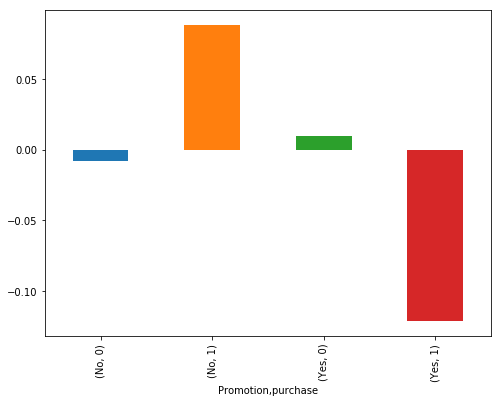

In [8]:
fig, ax = plt.subplots(figsize=(8,6))
gp4.plot(kind = 'bar', ax = ax)

In [9]:
train_data.groupby(['Promotion', 'purchase'])['V1'].agg({'V1_mean' : ['mean', 'std']})

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


V1_mean          
                        mean       std
Promotion purchase                    
No        0         1.496738  0.868296
          1         1.435737  0.858609
Yes       0         1.505559  0.868628
          1         1.474341  0.844735

## 3. Hypothesis Testing

Hypothesis Testing Steps:

1. Building Funnel of Users (not to be used here)
2. Diversion of Users (cookie based, event-based) (not to be used here)
3. Testing for the Invariant Metric
4. Testing for the Evaluation Metrics
5. Correction (Bonferroni or Sidark)
6. Experimental Size (not to be used here)
7. Validity, Bias, Ethics (not to be used here)
8. Analyzing Data 

In [10]:
#Taking Out the Experimental Group, Control Group Populations

n_total = train_data.shape[0]
print('n_total:', n_total)

n_control = train_data.query('Promotion == "No"').shape[0]
print('n_control:', n_control)

n_experiment = train_data.query('Promotion == "Yes"').shape[0]
print('n_experiment:', n_experiment)

n_total: 84534
n_control: 42170
n_experiment: 42364


**3.1 Testing Out Invariant Metric**

We are going to find out whether there is a significant difference between populations in control group vs those in the experimental group. If there is not a significant difference, it would mean we can carry out out testing without worrying for the effects for the bias that might have been introduced should the data have been imbalanced. We have been given that 

The null Hypothesis $H_{0}$ states that both the control and experimental group populations come from different groups of population and have a significant difference. The alternative Hypothesis $H_{a}$ states that both population groups come from same population group and have no significant difference between them

##### 3.1.1 Analytical Approach

In [11]:
#Compute a z-score and p-value
#Assuming a proportion/probability of 0.5 

probability = 0.5

standard_deviation = np.sqrt(probability * (1-probability) * n_total)

z_score = ((n_control + 0.5) - probability * n_total) / standard_deviation

print("The z-score for the Invariant Metric is {}".format(z_score))
print("The probability of seeing the control group population under the null values (p_value) is {} ".format(2 * stats.norm.cdf(z_score)))

The z-score for the Invariant Metric is -0.6638066506192843
The probability of seeing the control group population under the null values (p_value) is 0.5068140685419046 


##### 3.1.2 BootStrapping Approach

In [12]:
# # simulate outcomes under null, compare to observed outcome
probability = 0.5
n_trials = 200000

samples = np.random.binomial(n_total, probability, n_trials)

print("The probability of seeing the control group population under the null values (p_value) is {}".format( np.logical_or(samples <= n_control, samples >= (n_total - n_control)).mean()))

The probability of seeing the control group population under the null values (p_value) is 0.50594


Since the p value is greater than 0.05 , therefore we reject the null hypothesis that the difference is significant between both control and experimental population groups

## 3.2 Testing Out Evaluation Metrics

##### 3.2.1 Incremental Response Rate (IRR)

In order to test for the evaluation metric incremental response rate, we know that the incremental response rate (IRR) refers to the number of customers who bought the product "with promotion" as opposed to those who did NOT buy the product and DID NOT receive the promotion. 

Therefore, here our null hypothesis would be that IRR would be less than or equal to 0, i.e. that is promotion did not result in significant difference in number of customers buying the product. Whereas, the alternative hypothesis would be that IRR is greater than zero OR that the promotion sent did result in significant difference of purchase for the company. 

Hence:  $H_{0}: IRR <= 0$ 
and     $H_{a}: IRR > 0$

Moreover, we have also assumed alpha value to be 0.05 for our hyopthesis testing. However, since we are using more than one metric, therefore, we'll perform the bonferroni correction as follows

$$ Bonferroni Correction = \frac{a_{overall}}{number-of-metrics} = \frac{0.05}{2} = 0.025 $$

*IRR depicts how many more customers purchased the product with the promotion, as compared to if they didn't receive the promotion. Mathematically, IRR's the ratio of the number of purchasers in the promotion group to the total number of customers in the purchasers group (_treatment_) minus the ratio of the number of purchasers in the non-promotional group to the total number of customers in the non-promotional group (_control_).*

$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$



In [13]:
##Making the Required Calculations for Evaluating the Evaluation Metric
# proportion of customers who bought the product

proportion_total = train_data.purchase.mean()
print('proportion of customers in total:', proportion_total)

proportion_control = train_data.query('Promotion == "No"').purchase.mean()
print('proportion of customers for control group:', proportion_control)

proportion_experiment = train_data.query('Promotion == "Yes"').purchase.mean()
print('proportion of customers for experimental group:', proportion_experiment)

##OR::::
#These are all accurate calculations too
#proportion_tot = (purchase_treat + purchase_control)/ (customer_treat + customer_control)
#print('proportion of customers in total:', proportion_total)
#purchase_treat = train_data.query('Promotion == "Yes"').purchase.sum()
#purchase_control = train_data.query('Promotion == "No"').purchase.sum()
#customer_treat = train_data.query('Promotion == "Yes"').shape[0]
#customer_control = train_data.query('Promotion == "No"').shape[0]

proportion of customers in total: 0.0123027420919
proportion of customers for control group: 0.00756461939768
proportion of customers for experimental group: 0.0170191672174


In [15]:
calculated_IRR = proportion_experiment - proportion_control
#calculated_IRR = purchase_treat/customer_treat - purchase_control/customer_control
calculated_IRR

0.0094545478197727018

This calculated IRR is positive which suggests that the promotional campaign did have an effect on purchase of customers. **In order to find out whether that purchase had been significant we'd now perform the hypothesis testing**

##### 3.2.1.1 Analytical Approach

In [16]:
proportion_pooled = proportion_total

standard_error_p = np.sqrt(proportion_pooled * (1-proportion_pooled) * (1/n_control + 1/n_experiment))
print('Pooled Standard Error:', standard_error_p)
      
z_score = calculated_IRR / standard_error_p
print('Observed difference in IRR:', calculated_IRR)
      
print("The z_score for the evaluation metric IRR is:{}".format(z_score))
print("Probability of observing the difference when H0 is True is {}".format(1-stats.norm.cdf(z_score)))

Pooled Standard Error: 0.000758277751287
Observed difference in IRR: 0.00945454781977
The z_score for the evaluation metric IRR is:12.468449461599388
Probability of observing the difference when H0 is True is 0.0


##### 3.2.1.2 Bootstrapping Approach

In [17]:
n_trials = 20000


ctrl_sampled = np.random.binomial(n_control, proportion_total, n_trials)
exp_sampled = np.random.binomial(n_experiment, proportion_total, n_trials)
samples_IRR = exp_sampled / n_experiment - ctrl_sampled / n_control

print((samples_IRR >= (proportion_experiment - proportion_control)).mean())

0.0


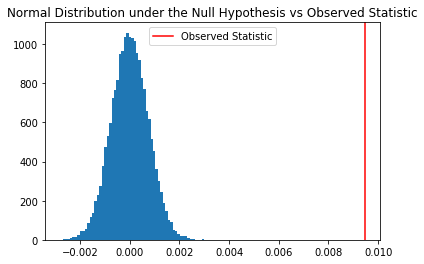

In [18]:
plt.axvline(calculated_IRR, color='r', label ="Observed Statistic")
null_IRR = np.random.normal(0, np.std(samples_IRR), 20000)
plt.hist(null_IRR, bins=60)
plt.title("Normal Distribution under the Null Hypothesis vs Observed Statistic")
plt.legend();

In [19]:
#Calculating p_value for the IRR

p_value = 1 - stats.norm.cdf(calculated_IRR, 0, np.std(samples_IRR))
print('The P-Value in this instance is:', p_value)

The P-Value in this instance is: 0.0


**Conclusion**

These findings indicate that since the p_value is less than alpha , we **reject the null hypothesis**. *That is, indeed our experiment has shown that there was a significant increase in the purchase with customers to whom the promotion was sent*

#### 3.2.2 : Net Incremental Revenue (NIR)


* **Evaluation Metric-Net Incremental Revenue (NIR)**

Now to test for the evaluation metric of net incremental revenue, we know that net incremental revenue refers to the profit made under the promotional campaign. If the value is positive, this would indicate that indeed there was a net profit as opposed to negative value which would indicate a loss. 

Therefore: the null hypothesis and alternative hypothesis are as follows:

$$H_0: NIR <= 0$$
$$H_a: NIR > 0$$

This is going to be a one-tailed experiment and the bonferroni correction is as follows:

$$ Bonferroni Correction = \frac{a_{overall}}{number-of-metrics} = \frac{0.05}{2} = 0.025 $$

*NIR depicts how much is made (or lost) by sending out the promotion. Mathematically, this is 10 times the total number of purchasers that received the promotion minus 0.15 times the number of promotions sent out, minus 10 times the number of purchasers who were not given the promotion.*

$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$


In [20]:
##Making the Required Calculations for Evaluating the Evaluation Metric
# proportion of customers who bought the product

purchase_treat = train_data.query('Promotion == "Yes"').purchase.sum()

customer_treat = train_data.query('Promotion == "Yes"').shape[0]

purchase_control = train_data.query('Promotion == "No"').purchase.sum()

#Calculation for the NIR is as follows: then:

calculated_NIR = (10*purchase_treat - 0.15*customer_treat) - 10*purchase_control
calculated_NIR

-2334.5999999999995

##### 3.2.2.1 Analytical Approach

In [21]:
proportion_pooled = proportion_total

standard_error_p = np.sqrt(proportion_pooled * (1-proportion_pooled) * (1/n_control + 1/n_experiment))
print('Pooled Standard Error:', standard_error_p)
      
z_score = calculated_NIR / standard_error_p
print('Observed difference in NIR:', calculated_NIR)
      
print("The z_score for the evaluation metric NIR is:{}".format(z_score))
print("Probability of observing the difference when H0 is True is {}".format(1-stats.norm.cdf(z_score)))

Pooled Standard Error: 0.000758277751287
Observed difference in NIR: -2334.6
The z_score for the evaluation metric NIR is:-3078819.0686574513
Probability of observing the difference when H0 is True is 1.0


##### 3.2.2.2 Bootstrapping Approach

In [22]:
n_trials = 20000

ctrl_sampled = np.random.binomial(n_control, proportion_total, n_trials)
exp_sampled = np.random.binomial(n_experiment, proportion_total, n_trials)
samples_NIR = (10*exp_sampled - 0.15*n_control) - 10*ctrl_sampled

print((samples_NIR >= (proportion_experiment - proportion_control)).mean())

0.0


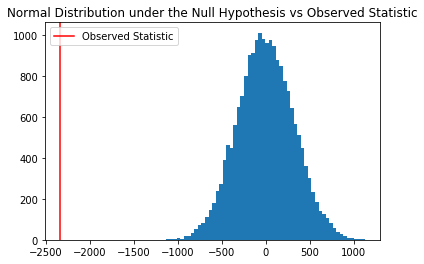

In [23]:
plt.axvline(calculated_NIR, color='r', label ="Observed Statistic")
null_NIR = np.random.normal(0, np.std(samples_NIR), 20000)
plt.hist(null_NIR, bins=60)
plt.title("Normal Distribution under the Null Hypothesis vs Observed Statistic")
plt.legend();

In [24]:
#Calculating p_value for the IRR

p_value = 1 - stats.norm.cdf(calculated_NIR, 0, np.std(samples_NIR))
print('The P-Value in this instance is:', p_value)

The P-Value in this instance is: 1.0


#### Conclusion

Since the p_value is more than our alpha , **we fail to reject the null hypothesis**. This indicates that promotional campaign did NOT result in any significant **(NIR)**. Perhaps changing the segment of clients would result in increase for NIR. 

## 3.3 Model Building

#### 3.3.1 Finding Correlation to See Relationship Between Variables

In [25]:
correlations = train_data.corr()
correlations

,ID,purchase,V1,V2,V3,V4,V5,V6,V7
ID,1.000000,0.006902,-0.004199,-0.002757,0.003296,-0.010600,0.000133,-0.001434,0.001686
purchase,0.006902,1.000000,-0.004906,-0.001694,-0.006395,0.032245,0.007814,-0.001538,-0.001117
V1,-0.004199,-0.004906,1.000000,-0.001564,0.003995,0.002568,-0.001196,-0.003672,0.001436
V2,-0.002757,-0.001694,-0.001564,1.000000,0.001165,0.002848,-0.001046,-0.004156,-0.002293
V3,0.003296,-0.006395,0.003995,0.001165,1.000000,0.003753,-0.001736,0.004464,0.001135
V4,-0.010600,0.032245,0.002568,0.002848,0.003753,1.000000,0.003161,0.002552,-0.003176
V5,0.000133,0.007814,-0.001196,-0.001046,-0.001736,0.003161,1.000000,-0.003043,0.003571
V6,-0.001434,-0.001538,-0.003672,-0.004156,0.004464,0.002552,-0.003043,1.000000,-0.001398
V7,0.001686,-0.001117,0.001436,-0.002293,0.001135,-0.003176,0.003571,-0.001398,1.000000


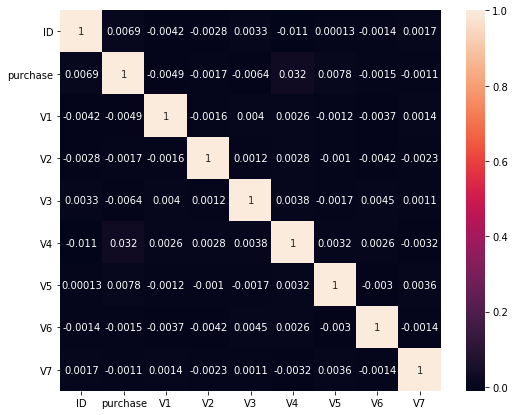

In [26]:
fig, ax = plt.subplots(figsize=(9,7))
sns.heatmap(correlations, annot = True, square = True, ax = ax)

**Findings**: Let us try and make different combinations by multiplying and adding V1 through V7 to make a new gp1 so that values of IRR and NIR are increased

In [27]:
#Making New Columns

train_data['manipul_1'] =  train_data.V1*train_data.V2*(train_data.V3)/train_data.V4
train_data['manipul_2'] =  train_data.V1*train_data.V2*train_data.V3/train_data.V5*train_data.V6
train_data.head(5)

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7,manipul_1,manipul_2
0,1,No,0,2,30.443518,-1.165083,1,1,3,2,-70.938474,-212.815423
1,3,No,0,3,32.159350,-0.645617,2,3,2,2,-31.143920,-41.525227
2,4,No,0,2,30.431659,0.133583,1,1,4,2,8.130330,32.521318
3,5,No,0,0,26.588914,-0.212728,2,1,4,2,-0.000000,-0.000000
4,8,Yes,0,3,28.044332,-0.385883,1,1,2,2,-32.465518,-64.931035


In [28]:
gp6 = train_data.groupby(['Promotion', 'purchase'])['manipul_1'].mean()
gp6

Promotion  purchase
No         0          -0.291197
           1           1.988165
Yes        0           0.410199
           1          -3.756956
Name: manipul_1, dtype: float64

Comments : Does this result help preditc the value to some extent? Or are more manipulations needed?

In [29]:
# Cells for you to work and document as necessary - 
# definitely feel free to add more cells as you need

### 3.3.2 Creating the Model Prediction

#### 3.3.2.1 Taking in Required Data

In [30]:
X = train_data.drop(['purchase', 'Promotion', 'ID', 'manipul_1', 'manipul_2'], axis = 1)
y = train_data.purchase

#### 3.3.2.2 Scaling the Features

In [39]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

def scaling(df):
    required_cols = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']

    for idx, col in enumerate(required_cols):
        df[[col]] = StandardScaler().fit_transform(df[[col]])

    return df

#scaling the features:

X = scaling(X)

#NOTE: X[[col]] is one column where X[col] is Series; hence the error of StandardScaler
#More information at https://stackoverflow.com/questions/58498187/sklearn-transform-error-expected-2d-array-got-1d-array-instead    

In [40]:
#from sklearn.preprocessing import LabelEncoder

#X[['Promotion']] = LabelEncoder().fit_transform(X[['Promotion']])


#### 3.3.2.3 Splitting the Data for Validation

In [41]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=1)

#### 3.3.2.4 Training the Model

In [42]:
from sklearn.ensemble import RandomForestClassifier
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

model_fitted = RandomForestClassifier()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
#rfc_cv_score = cross_val_score(rfc, X, y, cv=cv, scoring='roc_auc')
n_scores = cross_val_score(model_fitted, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)

In [43]:
model_fitted.fit(X_train, y_train)
#predictions = model_fitted.predict(X_test)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

#### 3.3.2.5 Verifying the Model Trained

In [46]:
predictions_valid_data_set = model_fitted.predict(X_val)

In [47]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

print("=== All Area_U_Curve Scores ===")
print(n_scores)
print('==========+++++=============')
print("accuracy of model is:", accuracy_score(y_val, predictions_valid_data_set))
print("========+++++==========")
print(confusion_matrix(y_val, predictions_valid_data_set))
print("========+++++==========")
print(classification_report(y_val, predictions_valid_data_set))

=== All Area_U_Curve Scores ===
[ 0.49854555  0.49537641  0.48309912  0.51838652  0.50374842  0.49628188
  0.50463874  0.52506688  0.51587605  0.4770085   0.48707391  0.51992296
  0.53342744  0.48618627  0.50795938  0.49743332  0.48844548  0.49202139
  0.48562659  0.47304535  0.49062092  0.47902274  0.51035317  0.5199194
  0.4961179   0.50259253  0.5180238   0.52522923  0.48981072  0.50751682]
==========+++++=============
accuracy of model is: 0.987519962146
========+++++==========
[[16696     8]
 [  203     0]]
========+++++==========
             precision    recall  f1-score   support

          0       0.99      1.00      0.99     16704
          1       0.00      0.00      0.00       203

avg / total       0.98      0.99      0.98     16907



#### 3.3.2.6 Reading In Test Data

In [48]:
test_data = pd.read_csv('./Test.csv')
test_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,2,No,0,1,41.376390,1.172517,1,1,2,2
1,6,Yes,0,1,25.163598,0.653050,2,2,2,2
2,7,Yes,0,1,26.553778,-1.597972,2,3,4,2
3,10,No,0,2,28.529691,-1.078506,2,3,2,2
4,12,No,0,2,32.378538,0.479895,2,2,1,2


In [50]:
X_test = test_data.drop(['Promotion', 'purchase', 'ID'], axis = 1)
y_test = test_data.purchase

#### 3.3.2.7 Scaling the Test Features

In [51]:
X_test = scaling(X_test)

#### 3.3.2.8 Prediction on Test_DataSet

In [52]:
predictions_testset = model_fitted.predict(X_test)

In [53]:
n_scores_sec = cross_val_score(model_fitted, X_test, y_test, scoring='roc_auc', cv=cv, n_jobs=-1)

#### 3.3.2.9 Evaluating the Prediction

In [55]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

print("=== All Area_U_Curve Scores ===")
print(n_scores_sec)
print('==========+++++=============')
print("accuracy of model is:", accuracy_score(y_test, predictions_testset))
print("========+++++==========")
print(confusion_matrix(y_test, predictions_testset))
print("========+++++==========")
print(classification_report(y_test, predictions_testset))

=== All Area_U_Curve Scores ===
[ 0.50199883  0.50537153  0.4832554   0.48672931  0.5402599   0.51277731
  0.545973    0.54124666  0.49149107  0.49218181  0.51080884  0.52308518
  0.50933123  0.53477198  0.50196846  0.48276961  0.50477947  0.50011386
  0.50143713  0.47978909  0.49654886  0.48134766  0.4778358   0.54285584
  0.49351773  0.53311473  0.50179894  0.50358271  0.49411991  0.49961542]
==========+++++=============
accuracy of model is: 0.987803121248
========+++++==========
[[41141    29]
 [  479     1]]
========+++++==========
             precision    recall  f1-score   support

          0       0.99      1.00      0.99     41170
          1       0.03      0.00      0.00       480

avg / total       0.98      0.99      0.98     41650



In [56]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    min_max_scaler = MinMaxScaler()
    df = min_max_scaler.fit_transform(df)
    
    #X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=1)
    #model = RandomForestClassifier()
    #cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    #n_scores = cross_val_score(model, X_train, y_val, scoring='accuracy', cv=cv, n_jobs=-1)
    
    y_pred = model_fitted.predict(df)
    
    promotion_yes_no = []
    for value in y_pred:
        if value == 0:
            promotion_yes_no.append("No")
        if value == 1:
            promotion_yes_no.append("Yes")
            
    promotion = np.asarray(promotion_yes_no)
    
    
    
    return promotion

In [57]:
# This will test your results, and provide you back some information 
# on how well your promotion_strategy will work in practice

test_results(promotion_strategy)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0000.

Your nir with this strategy is -0.30.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.0, -0.29999999999999999)